In [1]:
from dataset import CustomDataset
import pandas as pd
from networks import Baseline_net, BrainClassifier
import torch
from torchvision import transforms
from utils import boundarization
import numpy as np
import cv2

In [2]:
df = pd.read_csv("./CSV/brain_valid_central.csv")
testData=CustomDataset(df, False, mode="brain")
testloader = torch.utils.data.DataLoader(testData, batch_size=1, shuffle=False, collate_fn=lambda x:x)

In [3]:

net= Baseline_net(3,"unet", data="brain", backbone="vgg")
cnet = BrainClassifier(3, backbone="vgg")
net.load_state_dict(torch.load("./models/Brain_Baseline_Unet_no_classifier/net.pkl"))
cnet.load_state_dict(torch.load("./models/Brain_Baseline_Unet/classifier.pkl"))
red = np.full((256,256,3), (255,0,0), dtype="uint8")
for i, sample in enumerate(testloader):
    out = net(torch.stack([sa["image"] for sa in sample], dim=0).type(torch.float32))
    out = torch.where(out>0.6, 1.0, 0.0)
    out = out.squeeze()
    label = torch.stack([sa["label"] for sa in sample], dim=0)
    label = label.squeeze()
    out = out.detach().numpy()
    label = label.detach().numpy()
    
    mask_out = boundarization((out*255).astype("uint8"))
    mask_label = boundarization((label*255).astype("uint8"))
    rout = cv2.bitwise_and(red,red, mask=mask_out)
    rlabel = cv2.bitwise_and(red,red, mask=mask_label)
    origin = np.array(sample[0]["pilimage"])
    oout = cv2.bitwise_and(origin,origin, mask=255-mask_out)
    olabel = cv2.bitwise_and(origin,origin,mask=255-mask_label)
    
    out = torch.Tensor((oout+rout))
    label = torch.Tensor((olabel+rlabel))
    
    out=torch.cat((out,label),dim=1)
    out= torch.swapaxes(out, -1,0)
    out = torch.swapaxes(out, -1,-2)
    pilResult=transforms.ToPILImage()(out)
    id =sample[0]["id"]
    pilResult.save(f"./Result/{id}")
    

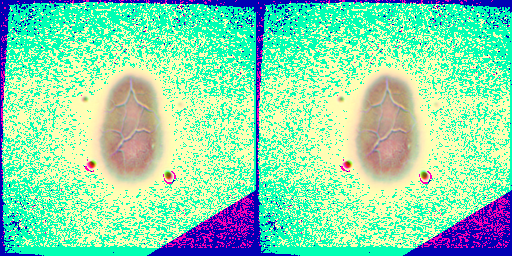

In [4]:
pilResult